# Check the rotation of strain to obtain SHmax

We compute the principal strain axis and the SHmax for the compressin in the consistent sign convension.
We aim to implement the output of SHmax in PyTAGS.

2023.7.10 Kurama Okubo

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import glob

import shutil
from tqdm import tqdm

import matplotlib.patches as patches
import matplotlib as mpl

from BP_rotate_strain import *

%load_ext autoreload
%autoreload 2

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["xtick.minor.width"] = 0
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True


In [2]:
output_imgdir = "./figure"
if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

# Sign convension and formulations to compute SHmax

<img src="compressive_SHmax_schematic.png" alt="drawing" width="800"/>


Note that East-West (Eee) and North-South (Enn) correspond to x and y axes, respectively. As the extension is positive, the SHmax indicating the maximum compressive stress (strain) corresponds to the orthogonal to the principal direction. The $\theta$ always corresponds to the maximum extensive direction in this sign convension.

# Work flow

1. Prepare the stress and strain states without shear stress as true model.
2. Rotate the strain to meet the condisions listed in the figure above.
3. compute SHmax and check if it is identical to the given rotation angle from the true model.
4. compute the maximum compressive strain to check if it is identical to the true model.

# Note:

Once the strain is rotated, we cannot reconstruct how much we rotate from the true model as we have two equivalent true model from which the stress state is obtained (see the two triangles in Figure above).

# Prepare the true model of stress state 

## Case 1. sxx > syy 

In this case, the SHmax is 90$^\circ$ parallel to the $\sigma_{yy}$.

In [3]:
# Synthesize the stress
nu = 0.25
E = 100e9
sxx0 = -10e6
syy0 = -20e6
tau0 = 0
e_true =  compute_strain(sxx0, syy0, tau0, E, nu)

if e_true[0][0] > e_true[1][1]:
    e_SHmax_true = e_true[1][1]
else:
    e_SHmax_true = e_true[0][0]

print(f"Eee={e_true[0][0]:.8f}, Enn={e_true[1][1]:.8f}, Een={e_true[0][1]:.8f}")

Eee=-0.00003125, Enn=-0.00015625, Een=0.00000000


### Rotate clockwise

In [4]:
theta_deg_case1 = -70
Eee, Enn, Een = rotate_strain(e_true[0][0], e_true[1][1], e_true[0][1], theta_deg_case1)
print(Eee, Enn, Een)
print(Eee>Enn, Een>0)

-0.00014162777769493608 -4.587222230506388e-05 4.0174225605408716e-05
False True


In [5]:
theta = 0.5*np.arctan2(2*Een, (Eee - Enn))
print(2*Een, (Eee - Enn), theta)
theta_p = np.rad2deg(theta)
theta_SHmax = theta_p + 90
print(f"theta_principal:{theta_p:.4f} theta_SHmax:{theta_SHmax:.4f}")

# assert np.abs(theta_deg_case1 + theta_p) < 1e-12 # check the rotation angle is correct

8.034845121081743e-05 -9.57555553898722e-05 1.2217304763960306
theta_principal:70.0000 theta_SHmax:160.0000


In [6]:
# compute the maximum compressive strain
e_SHmax = compute_axialstrain(Eee, Enn, Een, theta_SHmax)
print(f"e_SHmax: {e_SHmax:.4e}, true model: {e_SHmax_true:.4e}")
assert np.abs(e_SHmax_true - e_SHmax) < 1e-12 # check the rotation angle is correct

e_SHmax: -1.5625e-04, true model: -1.5625e-04


### Rotate anticlockwise

In [7]:
theta_deg_case1 = 70
Eee, Enn, Een = rotate_strain(e_true[0][0], e_true[1][1], e_true[0][1], theta_deg_case1)
Eee, Enn, Een
print(Eee>Enn, Een>0)

False False


In [8]:
theta = 0.5*np.arctan2(2*Een, (Eee - Enn))
theta_p = np.rad2deg(theta)
theta_SHmax = theta_p + 90
print(f"theta_principal:{theta_p:.4f} theta_SHmax:{theta_SHmax:.4f}")

# assert np.abs(theta_deg_case1 + theta_p) < 1e-12 # check the rotation angle is correct

theta_principal:-70.0000 theta_SHmax:20.0000


In [9]:
# compute the maximum compressive strain
e_SHmax = compute_axialstrain(Eee, Enn, Een, theta_SHmax)
print(f"e_SHmax: {e_SHmax:.4e}, true model: {e_SHmax_true:.4e}")
assert np.abs(e_SHmax_true - e_SHmax) < 1e-12 # check the rotation angle is correct

e_SHmax: -1.5625e-04, true model: -1.5625e-04


# Case 2. syy > sxx 

In this case, the SHmax is 0$^\circ$ parallel to the $\sigma_{xx}$.

In [10]:
sxx0 = -40e6
syy0 = -10e6
tau0 = 0
e_true =  compute_strain(sxx0, syy0, tau0, E, nu)

if e_true[0][0] > e_true[1][1]:
    e_SHmax_true = e_true[1][1]
else:
    e_SHmax_true = e_true[0][0]

print(f"Eee={e_true[0][0]:.8f}, Enn={e_true[1][1]:.8f}, Een={e_true[0][1]:.8f}")

Eee=-0.00034375, Enn=0.00003125, Een=0.00000000


### Rotate clockwise

In [11]:
theta_deg_case2 = -20
Eee, Enn, Een = rotate_strain(e_true[0][0], e_true[1][1], e_true[0][1], theta_deg_case2)
print(Eee, Enn, Een)
print(Eee>Enn, Een>0)

-0.0002998833330848084 -1.2616666915191606e-05 -0.00012052267681622612
False False


In [12]:
theta = 0.5*np.arctan2(2*Een, (Eee - Enn))
# print(2*Een, (Eee - Enn), theta)
theta_p = np.rad2deg(theta)
theta_SHmax = theta_p + 90
print(f"theta_principal:{theta_p:.4f} theta_SHmax:{theta_SHmax:.4f}")
print(theta_deg_case2, theta_p)
# assert np.abs(theta_deg_case2 + theta_p + 90) < 1e-12 # check the rotation angle is correct; We cannot chose this as we have equivalent two options.

theta_principal:-70.0000 theta_SHmax:20.0000
-20 -70.00000000000001


In [13]:
# compute the maximum compressive strain
e_SHmax = compute_axialstrain(Eee, Enn, Een, theta_SHmax)
print(f"e_SHmax: {e_SHmax:.4e}, true model: {e_SHmax_true:.4e}")
assert np.abs(e_SHmax_true - e_SHmax) < 1e-12 # check the rotation angle is correct

e_SHmax: -3.4375e-04, true model: -3.4375e-04


In [14]:
e_SHmax_true, e_SHmax

(-0.00034375, -0.00034375)

### Rotate anticlockwise

In [15]:
theta_deg_case2 = 20
Eee, Enn, Een = rotate_strain(e_true[0][0], e_true[1][1], e_true[0][1], theta_deg_case2)
Eee, Enn, Een
print(Eee>Enn, Een>0)

False True


In [16]:
theta = 0.5*np.arctan2(2*Een, (Eee - Enn))
print(2*Een, (Eee - Enn), theta)
theta_p = np.rad2deg(theta)
theta_SHmax = theta_p + 90
print(f"theta_principal:{theta_p:.4f} theta_SHmax:{theta_SHmax:.4f}")

# assert np.abs(theta_deg_case2 + theta_p - 90) < 1e-12 # check the rotation angle is correct

0.00024104535363245224 -0.0002872666661696168 1.2217304763960308
theta_principal:70.0000 theta_SHmax:160.0000


In [17]:
# compute the maximum compressive strain
e_SHmax = compute_axialstrain(Eee, Enn, Een, theta_SHmax)
print(f"e_SHmax: {e_SHmax:.4e}, true model: {e_SHmax_true:.4e}")
assert np.abs(e_SHmax_true - e_SHmax) < 1e-12 # check the rotation angle is correct

e_SHmax: -3.4375e-04, true model: -3.4375e-04


# Check all the variation of rotation

The symmerty of `np.arctan2` needs to be carefully chosen to obtain the correct SHmax.

In [18]:
truemodel_rotation = np.linspace(-360, 360, 49)
truemodel_rotation

array([-360., -345., -330., -315., -300., -285., -270., -255., -240.,
       -225., -210., -195., -180., -165., -150., -135., -120., -105.,
        -90.,  -75.,  -60.,  -45.,  -30.,  -15.,    0.,   15.,   30.,
         45.,   60.,   75.,   90.,  105.,  120.,  135.,  150.,  165.,
        180.,  195.,  210.,  225.,  240.,  255.,  270.,  285.,  300.,
        315.,  330.,  345.,  360.])

In [19]:
truemodel_rotation = np.linspace(-360, 360, 49)

nu = 0.25
E = 100e9

stress_list = [[-10e6, -20e6, 0], [-40e6, -10e6, 0]] # stress state of true model 

SHmax_all = dict()

for i, sig in enumerate(stress_list):
    
    sxx0, syy0, tau0 = sig
    e_true =  compute_strain(sxx0, syy0, tau0, E, nu)

    if e_true[0][0] > e_true[1][1]:
        e_SHmax_true = e_true[1][1]
        print(f"theta_SHmax true model: {90:.2f}")
    else:
        e_SHmax_true = e_true[0][0]
        print(f"theta_SHmax true model: {0:.2f}")

    print(f"Eee={e_true[0][0]:.8f}, Enn={e_true[1][1]:.8f}, Een={e_true[0][1]:.8f}")

    th = []
    for angle in truemodel_rotation:
        Eee, Enn, Een = rotate_strain(e_true[0][0], e_true[1][1], e_true[0][1], angle)
        # compute the pricipal orientation
        theta = 0.5*np.arctan2(2*Een, (Eee - Enn))
        theta_p = np.rad2deg(theta)
        # SHmax is orthogonal to the principal axis corresponding to the maximum extensive strain
        theta_SHmax = theta_p + 90
        if np.abs(theta_SHmax - 180) < 1e-12:
            theta_SHmax = 0 # unify the zero and 180 degrees to zero.
        
#         print(f"theta_principal:{theta_p:.4f} theta_SHmax:{theta_SHmax:.4f}")        
        # compute the maximum compressive strain
        e_SHmax = compute_axialstrain(Eee, Enn, Een, theta_SHmax)
        assert np.abs(e_SHmax_true - e_SHmax) < 1e-12 # check the rotation angle is correct
        
        print(f"angle:{angle:.1f}deg, theta_SHmax:{theta_SHmax:.1f}deg, e_SHmax: {e_SHmax:.4e}, true model: {e_SHmax_true:.4e}")
        th.append(theta_SHmax)
        
    SHmax_all[i]=th

theta_SHmax true model: 90.00
Eee=-0.00003125, Enn=-0.00015625, Een=0.00000000
angle:-360.0deg, theta_SHmax:90.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-345.0deg, theta_SHmax:75.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-330.0deg, theta_SHmax:60.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-315.0deg, theta_SHmax:45.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-300.0deg, theta_SHmax:30.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-285.0deg, theta_SHmax:15.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-270.0deg, theta_SHmax:0.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-255.0deg, theta_SHmax:165.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-240.0deg, theta_SHmax:150.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-225.0deg, theta_SHmax:135.0deg, e_SHmax: -1.5625e-04, true model: -1.5625e-04
angle:-210.0deg, theta_SHmax:120.0deg, e_SHmax: -1.5625e-04, true model: -1.562

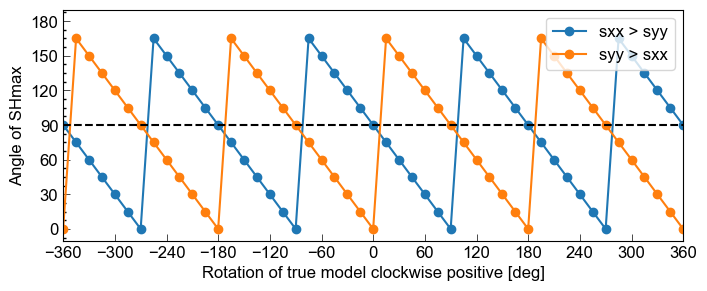

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(truemodel_rotation, SHmax_all[0], "-o", label="sxx > syy")
ax.plot(truemodel_rotation, SHmax_all[1], "-o", label="syy > sxx")
ax.set_xlabel("Rotation of true model clockwise positive [deg]")
ax.set_ylabel("Angle of SHmax")
ax.set_xlim([-360, 360])
ax.set_ylim([-10, 190])
ax.set_xticks(np.linspace(-360, 360, 13))
ax.set_yticks([0, 30, 60, 90, 120, 150, 180])
ax.legend(loc=0)
ax.axhline(90, c="k", ls="--")

# Conclusion

We can implement the orientation of SHmax using the function as follows:
```
# compute the pricipal orientation
theta = 0.5*np.arctan2(2*Een, (Eee - Enn))
theta_p = np.rad2deg(theta)
# SHmax is orthogonal to the principal axis corresponding to the maximum extensive strain
theta_SHmax = theta_p + 90
if np.abs(theta_SHmax - 180) < 1e-12:
    theta_SHmax = 0 # unify the zero and 180 degrees to zero.

print(f"theta_principal:{theta_p:.4f} theta_SHmax:{theta_SHmax:.4f}")        
# compute the maximum compressive strain
e_SHmax = compute_axialstrain(Eee, Enn, Een, theta_SHmax)
```

Note that the principal direction in `PyTAGS` is impelemented as followings:
    The principal direction is defined as `0.5*np.arctan2(2*Een, (Enn - Eee))`. Then, the `e1` and `e2` are calculated with replacing `theta` with `-theta` from the common formula of rotation.